#Gas Storage Valuation with Forward Trading

A widely used approach for gas storage valuation is the rolling intrinsic value, which is often used to price storage contracts and to derive trading decisions. However, it is well-known that the result underestimates the true value of storage since the rolling intrinsic value is a conservative figure. We are therefore going to conduct a *stochastic* rolling intrinsic valuation, which has been proposed in the article "[Optimal gas storage valuation and futures trading under a high-dimensional price process](http://www.optimization-online.org/DB_FILE/2015/05/4913.pdf)" by Nils Löhndorf and David Wozabal (2015).

The stochastic rolling intrinsic value can be obtained from computing the discounted cash flow of the optimal operational and trading policies. An optimal policy does not only need to consider the possible evolution of storage over time but also the dynamics of the forward curve as well as possible positions of all forward contracts that are held over time. The resulting stochastic-dynamic optimization problem has a high dimensionality, but by combining the discrete lattice with QUASAR's powerful approximate dynamic programming engine, the valuation problem can be solved in a short amount of time.

## Model Parameters
The model parameters for the storage system are taken from the Operations Research article by Lai, Margot, and Secomandi (2015), so are the interest rates.

In [1]:
season = 'Spring'
max_storage = 1.0
loss = 0.01
max_inject = 0.15
max_withdraw = 0.3
injection_cost = 0.02
withdrawal_cost = 0.01
interest = {
    'Spring': 0.0474,
    'Summer': 0.0505,
    'Fall': 0.0501,
    'Winter': 0.0487
}

## Multifactor Model
We will use the same multifactor model as in the Notebook [MultifactorLattice.ipynb](MultifactorLattice.ipynb). The lattice created in that notebook will now be imported to be used for optimization.

In [2]:
from pyquasar import *
num_months = 24
forwards_csv = pd.read_csv('assets/forwards.csv', index_col=0)
forward_curve = forwards_csv[season].values.tolist()[:num_months]
num_nodes = 50
lattice = Lattice.from_csv('MGBM_%d-node-lattice_%s'%(num_nodes,season))

## Model Formulation
The model maximizes the expected value of the discounted cash flows from buying and selling forward contracts while fulfilling matured contracts as well as injecting and withdrawing into and from storage. Additionally, the following assumptions are made:

- injection and withdrawal limits are independent of the storage level, i.e., ratchets are ignored, 
- cash flows are generated in monthly time increments,
- all forward positions yield a physically implementable policy under the given operational constraints.

The model formulation separates the problem into a *here-and-now* part and into a *wait-and-see* part.

The *here-and-now* part concerns the physical delivery of gas at each stage that must be balanced with the contract maturing at that stage. If we were to ignore future trading, this model would sufficiently describe the storage valuation problem.

The *wait-and-see* part ensures that all contractual positions made at the forward market yield an implementable policy under the currently held forward positions and physical state of the storage. A feasible policy that would ignore possible future decisions and states, would be to greedely rebalance the forward positions while meeting its obligations of matured contracts in an optimal way.

In [3]:
# initial state
prev_future = [0.]*num_months
prev_storage_0 = 0.

# define model
model = DecisionProblem("GasStorageValuation").maximize() 
for t in range(num_months):   
    
    # define some parameters
    tradable_futures = range(t+1,num_months)
    prompt_month = t
        
    # here-and-now model
    inject_0, withdraw_0, buy_0, sell_0, storage_0 = model.add_variables(t,"inject_0","withdraw_0","buy_0","sell_0","storage_0")
    #bounds
    model += inject_0 <= max_inject
    model += withdraw_0 <= max_withdraw
    model += storage_0 <= max_storage
    model += buy_0 <= max_storage
    model += sell_0 <= max_storage
    #constraints
    model += storage_0 == prev_storage_0 + (1-loss)*inject_0 - (1+loss)*withdraw_0
    model += prev_future[prompt_month] + buy_0 - sell_0 == inject_0 - withdraw_0
    #objective
    here_and_now_profit = -injection_cost*inject_0 - withdrawal_cost*withdraw_0
    if t>0:
        here_and_now_profit += rand("price_%d"%t)*sell_0 - rand("price_%d"%t)*buy_0
    else:
        here_and_now_profit += forward_curve[0]*sell_0 - forward_curve[0]*buy_0
    prev_storage_0 = storage_0

    wait_and_see_profit = Expression()
    for i in tradable_futures:
        # add variables for future planning periods
        inject_i, withdraw_i = model.add_variables(t,"inject_%d"%i, "withdraw_%d"%i)
        buy_i, sell_i = model.add_variables(t,"buy_%d"%i,"sell_%d"%i)
        storage_i, future_i = model.add_variables(t,"storage_%d"%i,"future_%d"%i)
        #bounds
        model += future_i >= -max_storage
        model += future_i <= max_storage
        model += storage_i <= max_storage
        model += inject_i <= max_inject
        model += withdraw_i <= max_withdraw
        #model += buy_i <= max_storage
        #model += sell_i <= max_storage
        # future balance
        model += future_i == prev_future[i]  + buy_i - sell_i
        model += future_i == inject_i - withdraw_i
        if i==tradable_futures[0]:
            prev_storage_i = storage_0
        #constraints
        model += storage_i == prev_storage_i + (1-loss)*inject_i - (1+loss)*withdraw_i
        #state transition
        prev_storage_i = storage_i
        #objective
        discount_factor = 1./(1.+interest[season])**(i/12.)
        wait_and_see_profit += discount_factor*(rand("price_%d"%i)*sell_i - rand("price_%d"%i)*buy_i)
        #add expected cost to objective function to get the right intrinsic value (only do this for rolling intrinsic!)
        #model += -discount_factor*(injection_cost*inject_i + withdrawal_cost*withdraw_i)
        #state transition
        prev_future[i] = future_i
    
    #add discounted profits to objective function
    profit = 1./(1.+interest[season])**(t/12.)*here_and_now_profit+wait_and_see_profit
    model += profit

##Optimal  Value
To compute the optimal policy of the above problem, we create another instance of the DynamicOptimizer and run the algorithm to convergence. When the algorithm has converged, we are going to take a look at algorithm statistics from the last iterations before convergence.

In [4]:
opt_exp = DynamicOptimizer(model, lattice, remove_redundant_hyperplanes=False,
                        linear_solver='sulum',
                        linear_solver_license='LICENSE sulum slmlp 4.3 30-jun-2015 uncounted hostid=ANY _ck=c51efc8e94 sig=\"60PG453MNM3XG74U4RVJ2X1W5F32PWNPBSA5EXR22M09V6F1PVQBYHEGN05T97EDC1042ACHHH4G\"')
opt_exp.solve(min_iterations=400,max_iterations=400)
opt_exp.join()
opt_exp.stats.tail()

,expReward,simReward,stdError,hyperplanes,numSolves,duration
iter,,,,,,
396,6.49,10.93,2.02,424264,450251,94
397,6.49,9.76,1.87,425348,451388,94
398,6.49,9.44,1.90,426433,452525,94
399,6.49,8.36,1.93,427517,453662,94
400,6.49,7.80,1.98,428603,454799,95


In [5]:
opt_exp = DynamicOptimizer(model, lattice, linear_solver='clp',remove_redundant_hyperplanes=False)
opt_exp.solve(min_iterations=400,max_iterations=400)
opt_exp.join()
opt_exp.stats.tail()

,expReward,simReward,stdError,hyperplanes,numSolves,duration
iter,,,,,,
396,6.49,10.38,2.98,414273,450251,59
397,6.49,6.49,0.19,415324,451388,65
398,6.49,11.78,2.97,416398,452525,65
399,6.49,11.60,2.98,417453,453662,65
400,6.49,12.61,3.09,418509,454799,66


We can now simulate the optimal policy to compute the storage value and collect some information about the decision process.

In [6]:
sample_size = 1000
sim_exp = opt_exp.policy.simulate(sample_size = sample_size)
sim_exp.set_time_index(start='2006-03',freq='MS')

Let us compute the expected (risk-neutral) storage value and plot the distribution of discounted profits as well as a fan chart of possible storage content levels as they are distributed over time.

Exp Value (SE): 6.31 (0.28)


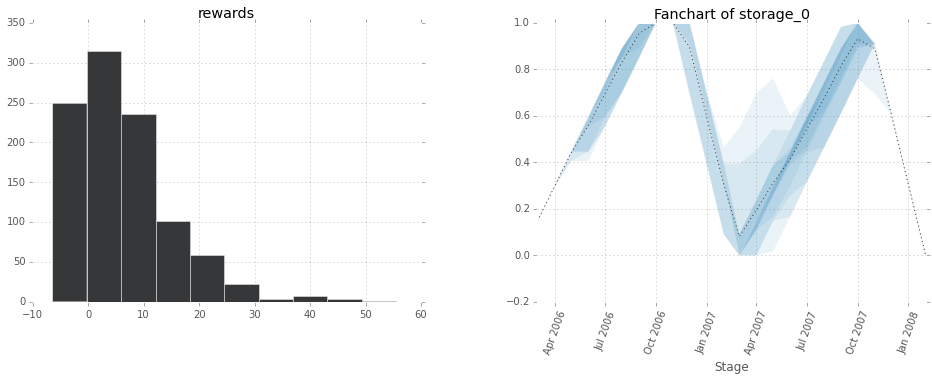

In [7]:
sum_exp_rewards = sim_exp.rewards.groupby_series.sum()
print "Exp Value (SE): %.2f (%.2f)"%(sum_exp_rewards.mean().values[0],sum_exp_rewards.std()/math.sqrt(sample_size))
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(16,5))
sum_exp_rewards.hist(ax=ax1)
sim_exp.decision.storage_0.fanchart(ax=ax2)

## Putting it All Back Together
Up to here, we have used the lattice in place of the multifactor model to obtain an optimal policy. However, the price model we are actually interested in is the multifactor model. We are therefore going to return to the multifactor model that has been used to create the lattice and then generate sample paths from the MGBM and apply our policy to these sample paths. If the gap between the discounted rewards of the policy under the discrete-state lattice and the continuous-state multifactor model is small, we can conclude that we have found the best possible policy.

Let us begin with importing the parameters that define the original multifactor price process, just like we did in the notebook [MultifactorLattice.ipynb](MultifactorLattice.ipynb). Again, we use the PyQuasar class MGBM to provide us with a simulator.

In [8]:
num_months = 24
# import the forward curve which also serves as initial value fo the MGBM
forwards_csv = pd.read_csv('assets/forwards.csv', index_col=0)
forward_curve = forwards_csv[season].values.tolist()[:num_months]
initial_values = forward_curve[1:num_months]
num_futures = len(initial_values)
# import the correlation matrix
correlation_csv = pd.read_csv('assets/correlation.csv', index_col=0)
correlation_matrix = correlation_csv.values.tolist()
# import the volatilities
volatility_csv = pd.read_csv('assets/volatility.csv', index_col=0)
volatilities = volatility_csv[season].mul(1./math.sqrt(12)).values.tolist()[:num_months]
# no drift
drift = [0.]*num_futures
# provide a name for each state variable
names = ['price_%d'%i for i in range(1,num_futures+1)]
mgbm = MGBM(names,initial_values,drift,volatilities,correlation_matrix)

As before, we can now simulate the optimal policy to compute the storage value and collect some information about the decision process, but this time we use the multifactor model for sampling.

Since the dynamic optimizer uses the lattice to find an optimal policy, we must specify how we apply the decision that has been made under the discrete policy to the continous MGBM process. We will do this by means of rounding to the nearest node on the lattice for which a decision is known.

In [9]:
sim_exp_mgbm = opt_exp.policy.simulate(process = mgbm, sample_size = sample_size, nearest_problem = True)
sim_exp_mgbm.set_time_index(start='2006-03',freq='MS')

Let us now take a look at the expected (risk-neutral) storage value and plot the distribution of discounted profits as well as a fan chart of possible storage content levels as they are distributed over time, just like we did before. As we can see, the profit figure approximately corresponds to the one computed when the lattice has been used.

Exp Value (SE): 6.76 (0.30)


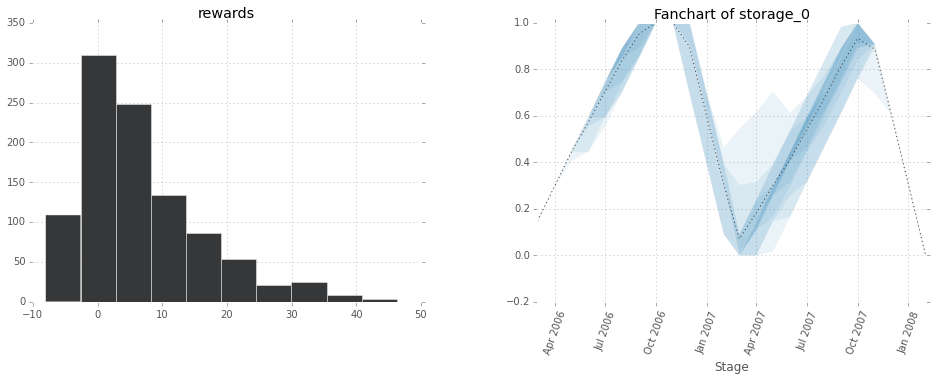

In [10]:
sum_exp_mgbm_rewards = sim_exp_mgbm.rewards.groupby_series.sum()
print "Exp Value (SE): %.2f (%.2f)"%(sum_exp_mgbm_rewards.mean().values[0],sum_exp_mgbm_rewards.std()/math.sqrt(sample_size))
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(16,5))
sum_exp_mgbm_rewards.hist(ax=ax1)
sim_exp_mgbm.decision.storage_0.fanchart(ax=ax2)

##Rolling Intrinsic Value

If we create an instance of PyQuasar's DynamicOptimizer without actually running it, the resulting policy will be greedy and thereby return the rolling intrinsic solution. To obtain the rolling intrinsic solution, we simply need to simulate the greedy policy. Again, we will use the multifactor model to generate sample paths.

In [11]:
opt_ri = DynamicOptimizer(model, mgbm, num_nodes=1)
sim_ri = opt_ri.policy.simulate(sample_size = sample_size, process = mgbm)
sim_ri.set_time_index(start='2006-03',freq='MS')

Exp Value (SE): 4.16 (0.01)


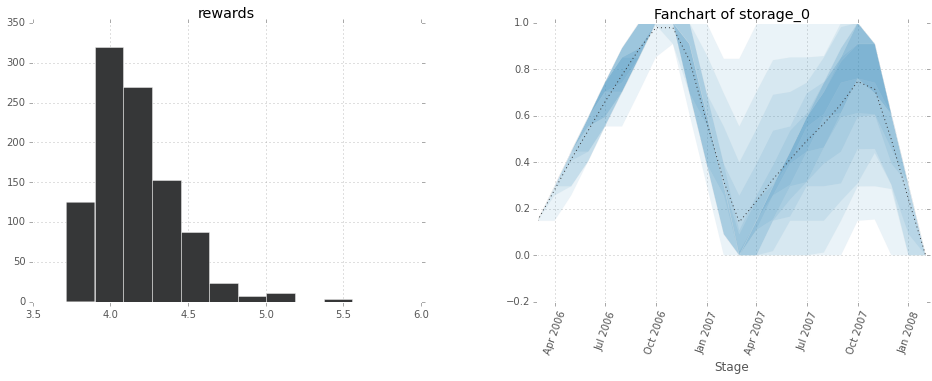

In [13]:
sum_ri_rewards = sim_ri.rewards.groupby_series.sum()
print "Exp Value (SE): %.2f (%.2f)"%(sum_ri_rewards.mean().values[0],sum_ri_rewards.std()/math.sqrt(sample_size))
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(16,5))
sum_ri_rewards.hist(ax=ax1)
sim_ri.decision.storage_0.fanchart(ax=ax2)